# Multiagent systems - TSP Problem

In [1]:
import tsplib95
from random import randrange, random, shuffle
from bisect import bisect
import pandas as pd
import matplotlib.pyplot as plt
# import pixiedust
import numpy as np

In [2]:
#!pip install ipython-autotime
%load_ext autotime

## Load TSP Problem

In [3]:
# Data Source : http://www.math.uwaterloo.ca/tsp/world/countries.html
#TSP_FILE = 'uy734.tsp' # 🇺🇾 Uruguay
TSP_FILE = 'wi29.tsp' # 🇪🇭 Western Sahara
#TSP_FILE = 'ca4663.tsp' # 🇨🇦 Canada

time: 314 µs


In [4]:
# LOAD TSP FILE
PROBLEM = tsplib95.load(TSP_FILE)
print(type(PROBLEM))

<class 'tsplib95.models.StandardProblem'>
time: 2.45 ms


In [5]:
PROBLEM.type

'TSP'

time: 2.03 ms


In [6]:
N = len(list(PROBLEM.get_nodes())) # N is total cities
print("%s Cities"%N)

29 Cities
time: 579 µs


In [7]:
# Example city coordinates
PROBLEM.node_coords[3]

[21300.0, 13016.6667]

time: 1.34 ms


In [8]:
# Distance between first and last cities
edge = {'start':1,'end':N}
PROBLEM.get_weight(**edge)

7799

time: 1.68 ms


## Basic Ant

In [9]:
HALF_MATRIX = True
class Ant:
    tour = None
    tsp = PROBLEM
    
    def __init__(self, city_i=0):
        self.tour = []
        if city_i>0:
            self.visit(city_i)
    
    @property
    def current_city(self):
        return self.tour[-1]

    @property
    def tour_weight(self):
        return self.tsp.trace_tours([self.tour])[0]
    
    def visit(self, i:int):
        if i in self.tour and i != self.tour[0]:
            raise Exception("The city i: %s is already visited. Imposible to visit again"%i)
        if i < 1 or i > N:
            raise Exception("The city i (%s) is out of range: -> [1, %s]"%(i, N))
        self.tour.append(i)
    
    def distance_to(self, city_j:int):
        return self.tsp.get_weight(self.current_city, city_j)
    
    def _not_visited_cities(self):
        return [i for i in range(1,N+1) if i not in self.tour]
    
    def _raw_probability(self, city_j:int, pheromones_matrix):
        ## ASSUMPTION: We consider the edge has two ways. Phromones to go and to go back. In other words. I->J != J->I
        # careful, we must substract one from the cities index
        if HALF_MATRIX:
            a = min([self.current_city-1, city_j-1])
            b = max([self.current_city-1, city_j-1])
        else:
            a = self.current_city-1
            b = city_j-1
        return (pheromones_matrix[a][b]**ALPHA) * ((1/self.distance_to(city_j))**BETA)
    
    def normalized_probabilities(self, pheromones_matrix):
        """ Returns a tuple
            First element: List of neighbors, cities not visited
            Second element: List of probabilities calculated with the formular of tau_ij^A* h_ij^B
        """
        neighbors = self._not_visited_cities()
        neighbors_pheromone_list = [self._raw_probability(neighbor_j, pheromones_matrix) for neighbor_j in neighbors]
        total = sum(neighbors_pheromone_list)
        normalized_probabilities = [pheromone_ij/total for pheromone_ij in neighbors_pheromone_list]
        #print(normalized_probabilities)
        return neighbors, normalized_probabilities
        
    def pick_next_city(self, cities, probabilities):
        roulette_x = random()
        idx = 0
        roulette_sum = 0
        for p in probabilities:
            roulette_sum += p
            if roulette_sum >= roulette_x  :
                return cities[idx]
            idx += 1
    
    def finished_tour(self):
        return len(self.tour) == N


time: 4.46 ms


In [10]:
a = Ant(1)
print(a.tour)
a.visit(29)
print(a.tour)
print("Total weight of this ant tour is: %s"%a.tour_weight)

[1]
[1, 29]
Total weight of this ant tour is: 15598
time: 1 ms


In [11]:
def plot_pheromones(df, step, show=True, title=''):
    print(title)
    if show:
        plt.imshow(df, cmap='hot', interpolation='nearest')
        plt.savefig("pheromones-%03d.png"%step)
        plt.show()
    #plt.imsave("pheromones-%03d.png"%step, df, cmap='hot')

time: 736 µs


## BASE LINE

In [12]:
# Solution joining all the cities in sequence
ant = Ant(1)
for i in range(2,N+1):
    ant.visit(i)
print(ant.tour)
print(ant.tour_weight)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
52284
time: 994 µs


In [13]:
# Random Solution
ant = Ant(1)
random_cities = list(range(2,N+1))
shuffle(random_cities)
for i in random_cities:
    ant.visit(i)
print(ant.tour)
print(ant.tour_weight)

[1, 22, 17, 10, 16, 19, 29, 27, 15, 25, 18, 4, 23, 11, 13, 28, 14, 2, 8, 24, 26, 12, 21, 20, 7, 3, 9, 5, 6]
99557
time: 1.21 ms


In [14]:
# Solution using the heuristic
ant = Ant(1)
while not ant.finished_tour():
    neighbors = ant._not_visited_cities()
    distances = []
    for city_j in range(1, len(neighbors)+1):
        distances.append(ant.distance_to(city_j))
    pos_min_distance = distances.index(min(distances))
    next_closest_city = neighbors[pos_min_distance]
    ant.visit(next_closest_city)
print(ant.tour)
print(ant.tour_weight)

[1, 2, 4, 7, 11, 16, 22, 29, 28, 27, 23, 26, 25, 24, 20, 21, 19, 18, 17, 14, 15, 13, 12, 8, 9, 6, 5, 10, 3]
56645
time: 3.67 ms


## ANT SYSTEM

In [30]:
def ant_system(show=True):
    # INIT MATRIX for each CITY IJ with TAU INITIAL (t_0)
    _pheromones_row = [TAU_INITIAL for i in range(N)]
    pheromones_matrix = [_pheromones_row for j in range(N)]

    history_list = []

    for step in range(STEPS):
        ants_list = []
        for ant_i in range(M_ANTS):
            # pick a starting point
            first_random_city = randrange(N)+1
            ant = Ant(first_random_city)
            ants_list.append(ant)
            while not ant.finished_tour():
                # calculate probability P_j for all unvisited neightbors J
                    # ANT SYSTEM (AS): Probability of each edge in the neighborhood
                    # p_ij_k = (t_ij^a * (1/d_ij)^b ) / SUM(all feasible g edges) # It's like edge normalized
                neighbors, probabilities = ant.normalized_probabilities(pheromones_matrix) # sum(probabilities) == 1
                # pick the next node using the probabilities
                next_city = ant.pick_next_city(neighbors, probabilities)
                ant.visit(next_city)
            ant.visit(first_random_city) # Close cycle??
        history_list.append(ants_list.copy()) # save results
        # update pheromone values based upon the quality of each solution
            # ANT SYSTEM (AS): All ants contribute updating the pheromone as follows
            # TAU_I_J = (1-RO)*TAU_I_J + SUM(Q/(Lk or 0)) # Attention! In TSP Lk will be always the same == N Total cities
                                               # Probably in TSP the length means the distance
        pheromones_to_add = [[0 for i in range(N)] for j in range(N)]
        for ant in ants_list:
            tau_delta = Q/ant.tour_weight
            for tour_i in range(1, len(ant.tour)):
                i = ant.tour[tour_i-1]-1 # city
                j = ant.tour[tour_i]-1 # next city
                if HALF_MATRIX:
                    a = min([i,j])
                    b = max([i,j])
                else:
                    a = i
                    b = j
                pheromones_to_add[a][b] += tau_delta
        # update fermonones
        df = pd.DataFrame(pheromones_matrix)*(1-RO)+pd.DataFrame(pheromones_to_add)
        pheromones_matrix = df.values
        # PLOT every 10th of steps
        if step % int(STEPS/10) == 0:
            plot_pheromones(df,step=step+1, title="Step %s from %s."%(step+1,STEPS), show=show)
    # Plot last result
    plot_pheromones(df,step=step+1, title="Step %s from %s."%(step+1,STEPS), show=True)
    return history_list, ants_list

time: 4 ms


In [26]:
M_ANTS = int(N) # Number of ants ~ to number of nodes (N)
for m in N:
    M_ANTS
    ALPHA = 1 # History coefficietn ~ 1
    BETA = 3 # 0,1,2,3,4,5,6 # Heuristic Coefficient [2,5]
    RO = 0.2# Evaporation rate # It's like cooling. A high value is similar to very decrease the temparature drastically and get stucked in a local optimum
    Q = 1*30000 # Pheromone change factor
    TAU_INITIAL = 1/70000 # Initial pheromone ~ 1/RO*C^nn ; C^nn is the length of the tour generated by the nearest neighbor heuristic
    STEPS = 100

    history_list, ants_list = ant_system(show=False)

Step 1 from 100.
Step 11 from 100.
Step 21 from 100.
Step 31 from 100.
Step 41 from 100.
Step 51 from 100.
Step 61 from 100.
Step 71 from 100.
Step 81 from 100.
Step 91 from 100.
Step 100 from 100.
time: 9.19 s


STARTING WITH 2 ANTS:
Step 1 from 100.
Step 11 from 100.
Step 21 from 100.
Step 31 from 100.
Step 41 from 100.
Step 51 from 100.
Step 61 from 100.
Step 71 from 100.
Step 81 from 100.
Step 91 from 100.
Step 100 from 100.


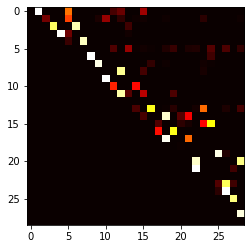

Min weigth: 34342
Best Tour: [21, 23, 22, 18, 19, 15, 10, 11, 12, 13, 9, 7, 3, 4, 5, 6, 1, 2, 8, 17, 16, 24, 27, 25, 26, 20, 14, 29, 28, 21]
STARTING WITH 4 ANTS:
Step 1 from 100.
Step 11 from 100.
Step 21 from 100.
Step 31 from 100.
Step 41 from 100.
Step 51 from 100.
Step 61 from 100.
Step 71 from 100.
Step 81 from 100.
Step 91 from 100.
Step 100 from 100.


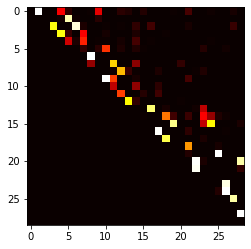

Min weigth: 29835
Best Tour: [17, 18, 19, 15, 11, 10, 12, 8, 4, 5, 1, 2, 6, 3, 7, 9, 13, 14, 16, 25, 27, 24, 20, 26, 28, 29, 21, 23, 22, 17]
STARTING WITH 6 ANTS:
Step 1 from 100.
Step 11 from 100.
Step 21 from 100.
Step 31 from 100.
Step 41 from 100.
Step 51 from 100.
Step 61 from 100.
Step 71 from 100.
Step 81 from 100.
Step 91 from 100.
Step 100 from 100.


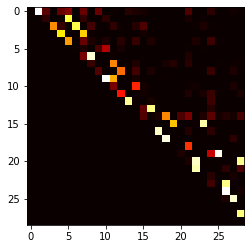

Min weigth: 29033
Best Tour: [22, 23, 21, 29, 28, 26, 20, 25, 27, 24, 16, 14, 13, 12, 10, 11, 6, 1, 2, 5, 4, 3, 7, 9, 8, 15, 19, 18, 17, 22]
STARTING WITH 8 ANTS:
Step 1 from 100.
Step 11 from 100.
Step 21 from 100.
Step 31 from 100.
Step 41 from 100.
Step 51 from 100.
Step 61 from 100.
Step 71 from 100.
Step 81 from 100.
Step 91 from 100.
Step 100 from 100.


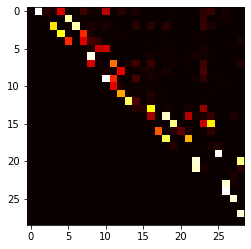

Min weigth: 28453
Best Tour: [15, 19, 18, 22, 23, 21, 29, 28, 26, 20, 16, 24, 27, 25, 17, 14, 13, 9, 7, 3, 4, 8, 5, 6, 2, 1, 11, 10, 12, 15]
STARTING WITH 10 ANTS:
Step 1 from 100.
Step 11 from 100.
Step 21 from 100.
Step 31 from 100.
Step 41 from 100.
Step 51 from 100.
Step 61 from 100.
Step 71 from 100.
Step 81 from 100.
Step 91 from 100.
Step 100 from 100.


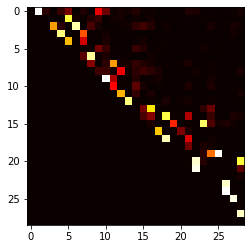

Min weigth: 27811
Best Tour: [9, 7, 3, 4, 8, 5, 6, 2, 1, 11, 10, 12, 15, 19, 18, 17, 21, 23, 22, 29, 28, 26, 20, 25, 27, 24, 16, 14, 13, 9]
STARTING WITH 12 ANTS:
Step 1 from 100.
Step 11 from 100.
Step 21 from 100.
Step 31 from 100.
Step 41 from 100.
Step 51 from 100.
Step 61 from 100.
Step 71 from 100.
Step 81 from 100.
Step 91 from 100.
Step 100 from 100.


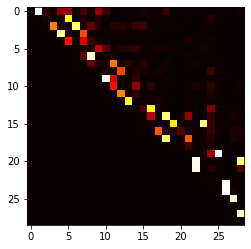

In [ ]:
for m in range(1,N+1):
    M_ANTS = 2*m # Number of ants ~ to number of nodes (N)
    print("STARTING WITH %d ANTS:"%M_ANTS)
    ALPHA = 1 # History coefficietn ~ 1
    BETA = 3 # 0,1,2,3,4,5,6 # Heuristic Coefficient [2,5]
    RO = 0.2# Evaporation rate # It's like cooling. A high value is similar to very decrease the temparature drastically and get stucked in a local optimum
    Q = 1*30000 # Pheromone change factor
    TAU_INITIAL = 1/70000 # Initial pheromone ~ 1/RO*C^nn ; C^nn is the length of the tour generated by the nearest neighbor heuristic
    STEPS = 100

    history_list, ants_list = ant_system(show=False)

    #Results
    all_ants_list = [ant for ants_step_list in history_list for ant in ants_step_list]
    all_tours_weight_list = [a.tour_weight for a in all_ants_list]
    pos_min = all_tours_weight_list.index(min(all_tours_weight_list))
    print("Min weigth: %s"%all_tours_weight_list[pos_min])
    best_ant = all_ants_list[pos_min]
    best_tour = best_ant.tour
    print("Best Tour: %s"%best_tour)

In [27]:
tours_weight_list = [a.tour_weight for a in ants_list]
print(tours_weight_list)

[39584, 33984, 38086, 32443, 31783, 34128, 34907, 37369, 34083, 38509, 31336, 37727, 36864, 36435, 46311, 36070, 33748, 36204, 32874, 31182, 32188, 32676, 37711, 33818, 32833, 36860, 35835, 30825, 31321]
time: 3.77 ms


In [18]:
#pos_min = tours_weight_list.index(min(tours_weight_list))
all_ants_list = [ant for ants_step_list in history_list for ant in ants_step_list]
all_tours_weight_list = [a.tour_weight for a in all_ants_list]
pos_min = all_tours_weight_list.index(min(all_tours_weight_list))
print("Min weigth: %s"%all_tours_weight_list[pos_min])
best_ant = all_ants_list[pos_min]
best_tour = best_ant.tour
print("Best Tour: %s"%best_tour)

Min weigth: 27811
Best Tour: [25, 27, 24, 16, 14, 13, 9, 7, 3, 4, 8, 5, 6, 2, 1, 11, 10, 12, 15, 19, 18, 17, 21, 23, 22, 29, 28, 26, 20, 25]
time: 345 ms


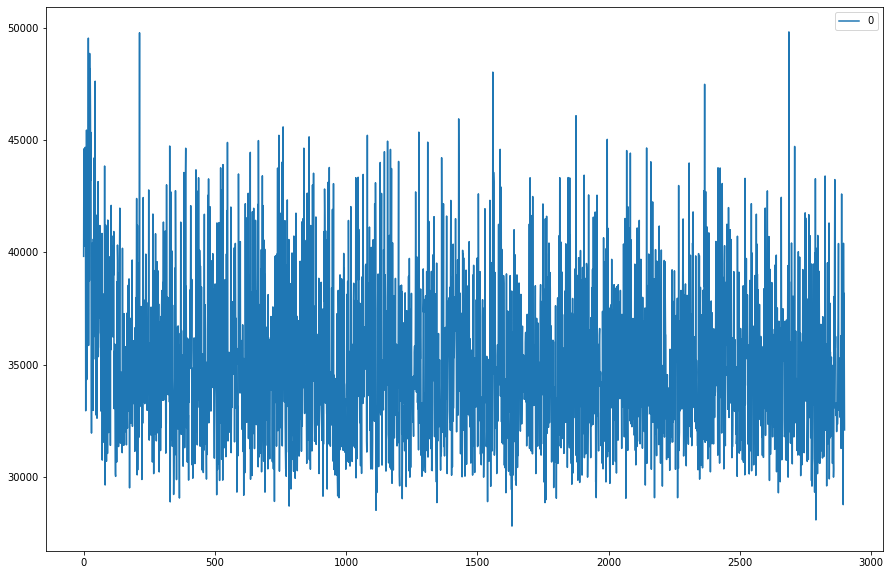

time: 263 ms


In [19]:
pd.DataFrame(all_tours_weight_list).plot(figsize=(15,10))

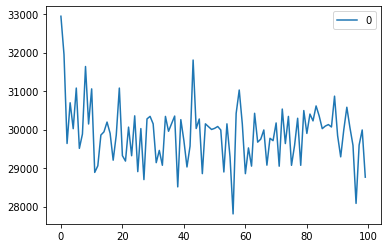

time: 487 ms


In [20]:
pd.DataFrame([min([a.tour_weight for a in ants_step_list]) for ants_step_list in history_list]).plot()

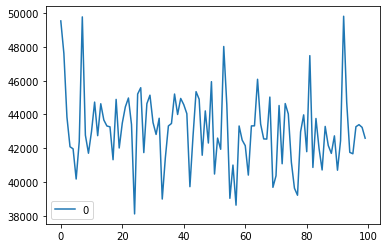

time: 451 ms


In [21]:
pd.DataFrame([max([a.tour_weight for a in ants_step_list]) for ants_step_list in history_list]).plot()

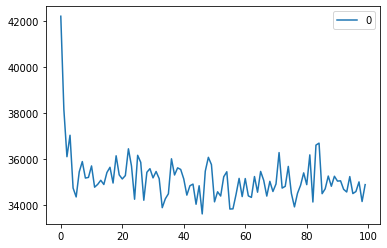

time: 453 ms


In [22]:
pd.DataFrame([np.mean([a.tour_weight for a in ants_step_list]) for ants_step_list in history_list]).plot()

30


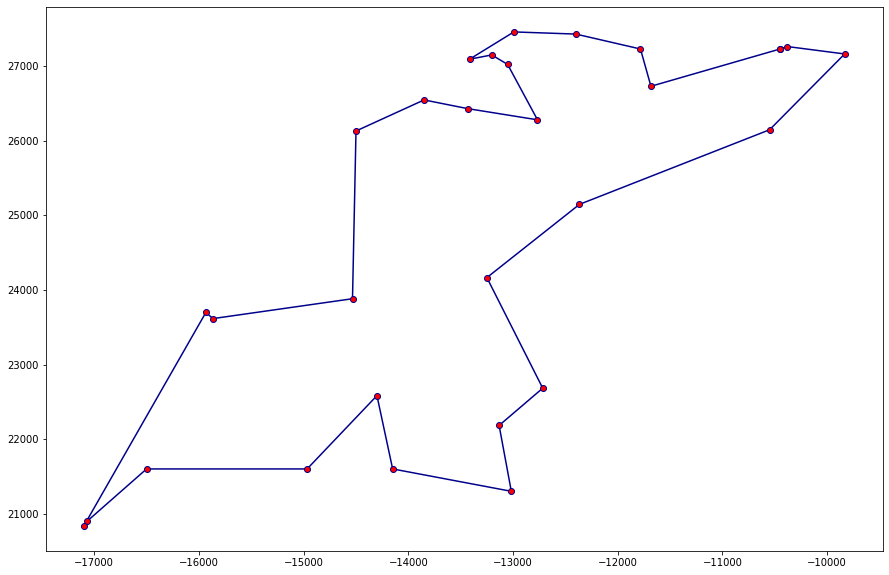

time: 170 ms


In [23]:
map_df_lat = pd.DataFrame([PROBLEM.node_coords[i][0] for i in best_tour], columns=['lat'])
map_df_long = pd.DataFrame([PROBLEM.node_coords[i][1] for i in best_tour], columns=['long'])*-1
print(len(map_df_lat))
plt.figure(figsize=(15,10))
plt.plot(map_df_long,
              map_df_lat,
              c='DarkBlue',
              #style=['o', 'rx'],
              #s=2,
              #figsize=(15,8),
              marker="o",
              markerfacecolor="r")

In [24]:
best_ant.tour_weight

27811

time: 1.73 ms
